In [2]:
import re
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

pd.set_option('notebook_repr_html', True)

In [3]:
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
league = ['GB1','FR1','L1','IT1','ES1']
league_page = "https://www.transfermarkt.com/jumplist/startseite/wettbewerb/"

In [4]:
def get_club_details(tr_tag):
    club = tr_tag.find_all('a',class_="vereinprofil_tooltip")[1]
    club_link = club['href']
    club_name = club.get_text()
    club_value = tr_tag.find_all('td',class_="rechts show-for-small show-for-pad nowrap")[0].get_text()
    return tuple((club_link,club_name,club_value))

In [5]:
clubs_list = []
for league_id in league:
    page = requests.get(league_page + league_id,headers = headers)
    soup = bs(page.content, 'html.parser')
    tbody_container = soup.find_all('tbody')[1]
    tr_container = tbody_container.find_all('tr')
    for tr_tag in tr_container :
        clubs_list.append(get_club_details(tr_tag))
print('All the club were uploaded')

All the club were uploaded


In [6]:
def get_players_club(player):
    player_id = player['id']
    player_link = player['href']
    player_name = player.get_text()
    return tuple((player_id,player_link,player_name,club_name,club_value))

In [7]:
url_site = "https://www.transfermarkt.com"
player_list = []
for club_link,club_name,club_value in clubs_list:
    page = requests.get(url_site + club_link,headers = headers)
    soup = bs(page.content, 'html.parser')
    tbody_container = soup.find_all('tbody')[1]
    players_details = tbody_container.find_all('a',class_="spielprofil_tooltip")
    for player in players_details[::2] :
        player_list.append(get_players_club(player))
print('All the players were uploaded')

All the players were uploaded


In [8]:
def get_profil_detail(soup):
    table_container = soup.find_all('table', class_="auflistung")[0]
    td_container = table_container.find_all('td')
    if td_container[1].find('a') == None:
        birth = td_container[0].find('a')['href'].split("/")[-1]# take it in format YYYY-MM-DD for datetime later
        height = td_container[3].get_text().split("m")[0]# I remove the m of meter 
        country = td_container[4].find('img')['title']
        role = td_container[5].get_text().strip()
        foot = td_container[6].get_text()
    else :
        birth = td_container[1].find('a')['href'].split("/")[-1]
        height = td_container[4].get_text().split("m")[0]# I remove the m of meter 
        country = td_container[5].find('img')['title']
        role = td_container[6].get_text().strip()
        foot = td_container[7].get_text()
    tbody_container = soup.find_all('tbody')[0]
    tr_transfer_container = tbody_container.find_all('tr',class_="zeile-transfer")
    transfer_list = []
    for tr_transfer_tag in tr_transfer_container:
        td_transfer_container = tr_transfer_tag.find_all("td")
        tranfer_from = td_transfer_container[5].get_text()
        transfer_to = td_transfer_container[9].get_text()
        transfer_season = td_transfer_container[0].get_text()
        transfer_date = td_transfer_container[1].get_text()
        transfer_list.append(tuple((tranfer_from,transfer_to,transfer_season,transfer_date)))
    return tuple((Id,name,club,club_value,birth,height,country,role,foot,link.split("/")[1],transfer_list))

In [9]:
player_details = []
i=0
for Id,link,name,club,club_value in player_list:
    i=i+1
    if i%500 == 0:
        print("new league upload")
    try:
        page = requests.get(url_site + link,headers = headers)
        soup = bs(page.content, 'html.parser')
        player_details.append(get_profil_detail(soup))
    except Exception as e:
        player_details.append(tuple((Id,name,club,club_value,None,None,None,None,None,link.split("/")[1],[])))
        continue
print("all player details uploaded")

new league upload


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


new league upload
new league upload


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


new league upload


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


new league upload


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


all player details uploaded


In [10]:
def get_injuries_details(soup):
    tbody_container = soup.find_all('tbody')[0]
    tr_container = tbody_container.find_all('tr')
    injuries_list = []
    for tr_tag in tr_container:
        season = tr_tag.find_all('td')[0]
        injury = tr_tag.find_all('td')[1]
        time_out = tr_tag.find_all('td')[4]
        injuries_list.append(tuple((season.get_text(),injury.get_text(),time_out.get_text().split()[0])))
    return injuries_list

In [11]:
player_list = []
for Id,name,club,club_value,birth,height,country,role,foot,name_link,transfer_list in player_details:
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
        page = requests.get("https://www.transfermarkt.com/{}/verletzungen/spieler/{}".format(name_link,Id),headers=headers)
        soup = bs(page.content, 'html.parser')
        player_list.append(tuple((Id,name,club,club_value,birth,height,country,role,foot,transfer_list,get_injuries_details(soup))))
    except Exception as e:
        player_list.append(tuple((Id,name,club,club_value,birth,height,country,role,foot,transfer_list,[])))
        continue
print("all player injuries details uploaded")
print("End of uploading from Transfermarkt")

all player injuries details uploaded
End of uploading from Transfermarkt


In [14]:
def get_list_club_lequipe(h2_tag,league_id):
    if league_id == 'EQ_D1' :
        club = h2_tag.find_all('a')[1]
        club_link = club['href']
        club_name = club['title']
        return tuple((club_link,club_name))
    else:
        club = h2_tag.find('a')
        club_link = club['href']
        club_name = club['title']
        return tuple((club_link,club_name))

In [15]:
league = ['EQ_ANG','EQ_D1','EQ_ALL','EQ_ITA','EQ_ESP']
league_page = "https://www.lequipe.fr/Football/"
clubs_list_lequipe = []
for league_id in league:
    print(league_id)
    page = requests.get(league_page + league_id + ".html",headers = headers)
    soup = bs(page.content, 'html.parser')
    tbody_container = soup.find_all('div',class_="listeclubs")[0]
    h2_container = tbody_container.find_all('h2')
    for h2_tag in h2_container :
        clubs_list_lequipe.append(get_list_club_lequipe(h2_tag,league_id))
print('All the club were uploaded')
url_site = "https://www.lequipe.fr"
player_list_lequipe = []
for club_link,club_name in clubs_list_lequipe:
    page = requests.get(url_site + club_link,headers = headers)
    soup = bs(page.content, 'html.parser')
    tbody_container = soup.find_all('table')[4]
    players_details = tbody_container.find_all('tr')
    for player in players_details[1:] :
        player_details = player.find_all('a')[0]
        weight = player.find_all('td')[6]
        player_name = player_details.get_text().strip()
        player_list_lequipe.append(tuple((player_name,club_name,weight.get_text())))
print("all player from lequipe were uploaded")
club_to_player_map = {}
for player in player_list_lequipe:
    if player[1] in club_to_player_map.keys():
        club_to_player_map[player[1]][player[0]] = player[2]
    else:
        club_to_player_map[player[1]] = {}
        club_to_player_map[player[1]][player[0]] = player[2]
#Just to verify the name
lequipe_clubs = club_to_player_map.keys()
print(lequipe_clubs)

EQ_ANG
EQ_D1


IndexError: list index out of range

In [16]:
import difflib
df_players = pd.DataFrame(player_list)
df_players.head()
Final_player = []
for player_transfertmarkt in player_list:
    try:
        list_of_players_lequipe = club_to_player_map[difflib.get_close_matches(player_transfertmarkt[2], lequipe_clubs,cutoff=0.1)[0]].keys()
        weight_player = club_to_player_map[difflib.get_close_matches(player_transfertmarkt[2], lequipe_clubs,cutoff=0.1)[0]][difflib.get_close_matches(player_transfertmarkt[1][:15], list_of_players_lequipe,cutoff=0.1)[0]]
        Final_player.append(tuple((player_transfertmarkt[0],player_transfertmarkt[1],player_transfertmarkt[2],player_transfertmarkt[3],player_transfertmarkt[4],weight_player,player_transfertmarkt[5],player_transfertmarkt[6],player_transfertmarkt[7],player_transfertmarkt[8],player_transfertmarkt[9],player_transfertmarkt[10])))
    except Exception as e:
        print(player_transfertmarkt[2])
        Final_player.append(tuple((player_transfertmarkt[0],player_transfertmarkt[1],player_transfertmarkt[2],player_transfertmarkt[3],player_transfertmarkt[4],None,player_transfertmarkt[5],player_transfertmarkt[6],player_transfertmarkt[7],player_transfertmarkt[8],player_transfertmarkt[9],player_transfertmarkt[10])))
print("END")
print(Final_player)
                                                                                                                                        
df_player = pd.DataFrame(Final_player)
df_player.columns = ["id", "name", "club","club_value","birth","height","weight","country","role","foot","transfers","injuries"]
df_player.head()
df_player.shape

Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Manchester City
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Liverpool FC
Chelsea FC
Chelsea FC
Chelsea FC
Chel

TSG 1899 Hoffenheim
TSG 1899 Hoffenheim
TSG 1899 Hoffenheim
TSG 1899 Hoffenheim
TSG 1899 Hoffenheim
TSG 1899 Hoffenheim
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
VfL Wolfsburg
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
FC Schalke 04
Eintracht Frankfurt
Eintracht Frankfurt
Eintracht Fran

Atlético Madrid
Atlético Madrid
Atlético Madrid
Atlético Madrid
Atlético Madrid
Atlético Madrid
Atlético Madrid
Atlético Madrid
Atlético Madrid
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Real Sociedad
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Sevilla FC
Valencia CF
Valencia CF
Valencia CF
Valencia CF
Valencia CF
Valencia CF
Valencia CF
Valencia CF
Valencia CF
Valencia CF
Valencia CF

(2815, 12)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pd.set_option('notebook_repr_html', True)

In [66]:
tuples = []
i=0
for t in open('Final-player.txt'):
    i=i+1
    if i == 2580:
        tuples.append(eval(t[1:-1]))
    else:
        tuples.append(eval(t[1:-2]))
df = pd.DataFrame(tuples)
df.columns = ["id", "name", "club","club_value","birth","weight","height","country","role","foot","transfers","injuries"]
number_of_players = df.shape[0]
df.shape
df.head()

#df['club'], df['club_value'] 

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,injuries
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...","[(16/17, Meniscal Injury, 29)]"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","[(18/19, Achilles tendon rupture, 314), (16/17..."
2,371021,Arijanet Murić,Manchester City,"1,14 Bill. €",1998-11-07,-,"1,98",Kosovo,Goalkeeper,right,"[(\nNAC Breda , \nMan City , 18/19, Aug 22, 20...",[]
3,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...","[(18/19, Muscle Injury, 6), (17/18, Minor Knoc..."
4,176553,Aymeric Laporte,Manchester City,"1,14 Bill. €",1994-05-27,85,"1,91",France,Defender - Centre-Back,left,"[(\nAthletic , \nMan City , 17/18, Jan 30, 201...","[(18/19, Muscle Injury, 12), (16/17, Groin Inj..."


In [67]:
df = df[df['birth'].notnull()]
number_of_new_players = df.shape[0]
df.shape

(2521, 12)

In [68]:
injuries_list = [injurie[1] for injurie in df['injuries'].sum()]
s = pd.Series(injuries_list).value_counts()
for injur in (s[s > 75].index):
    print(injur)

Hamstring Injury
Muscular problems
Muscle Injury
Ankle Injury
Unknown Injury
Knee Injury
Thigh Problems
Knee Problems
Torn Muscle Fibre
Knock
Minor Knock
Fitness
Adductor problems
Shoulder Injury
Cruciate Ligament Rupture
Back trouble
Influenza
Calf Injury
Thigh Muscle Strain
Ill
Calf Problems
Tear in the abductor muscle
Rest 
Groin Injury
Foot Injury
Achilles tendon problems
Bruise
groin strain
Muscle Fatigue
Ankle problems
Cold
Strain
Abdominal Influenza
Biceps femoris muscle injury
Flu
Concussion
Torn muscle bundle
Hip Injury
Leg Injury


In [69]:
s = df.apply(lambda x: pd.Series(x[11]),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'injurie'
df = df.drop(['injuries'], axis=1).join(s)
df.reset_index()
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,injurie
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...","(16/17, Meniscal Injury, 29)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(18/19, Achilles tendon rupture, 314)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(16/17, Disrupted Calf Muscle, 57)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Calf Injury, 17)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Torn muscle bundle, 24)"


In [70]:
df = df.reset_index(drop=True)
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,injurie
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...","(16/17, Meniscal Injury, 29)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(18/19, Achilles tendon rupture, 314)"
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(16/17, Disrupted Calf Muscle, 57)"
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Calf Injury, 17)"
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Torn muscle bundle, 24)"


In [71]:
df = df[df['injurie'].notnull()]
df.shape

df_injurie = pd.DataFrame(df['injurie'].tolist(), index=df.index)
df_injurie.head()

df = df.drop('injurie', axis=1).join(df_injurie)
df.head()

import datetime

df = df.rename(index=str, columns={0: "season", 1: "type" , 2 : "days"})
df.head()

df.to_excel(r'Injuries2.xlsx', index=False)


In [72]:
df.season = df.season.apply(lambda x : '20' + x[3:] + '-01-01')
df.head()

df.to_excel(r'Injuries.xlsx', index=False)

In [73]:
def injurie_age(season,birth):
    return datetime.datetime.strptime(season, '%Y-%m-%d').year - datetime.datetime.strptime(birth, '%Y-%m-%d').year

In [74]:
df['age'] = df.apply(lambda x : injurie_age(x['season'], x['birth']), axis=1)

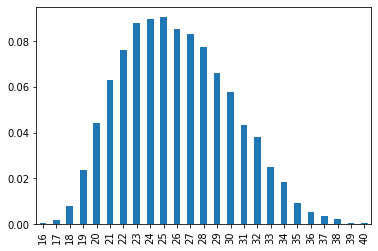

In [75]:
df[(df['age'] >= 16) & (df['age'] <= 40)]['age'].value_counts(normalize='true').sort_index().plot(kind='bar',style=None)

In [48]:
muscle_injurie = ['Hamstring Injury','Muscular problems','Muscle Injury','Torn Muscle Fibre',
                  'Adductor problems','Thigh Muscle Strain','Groin Injury','Muscle Fatigue',
                  'Achilles tendon problems','Torn muscle bundle','Biceps femoris muscle injury']

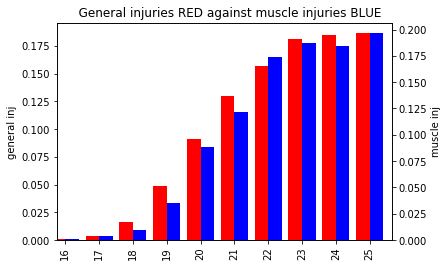

In [76]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
ax.set_title('   General injuries RED against muscle injuries BLUE')
width = 0.4

df[(df['age'] >= 16) & (df['age'] <= 25)]['age'].value_counts(normalize='true').sort_index().plot(kind='bar', color='red', ax=ax, width=width, position=1)
df[(df['type'].isin(muscle_injurie))
   & (df['age'] >= 16) & (df['age'] <= 25)]['age'].value_counts(normalize='true').sort_index().plot(kind='bar',color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('general inj')
ax2.set_ylabel('muscle inj')

plt.show()